***
***

# Assignment 2 - Extend My Playlist - 60 points

- This assignment will see you use a dataset of Spotify playlists, and build a GNN to build a playlist-track RecSys (Recommendation System). We'll use a type of layer called LightGCN for this task.
- You will almost certainly need a GPU for this assignment. The free tier GPUs of colab should suffice. So write your code with that in mind.
- The dataset you have been shared is a small part of a much larger dataset so the free tier colab GPU can handle it. Do **NOT** share the dataset with other people. We'll release details about the dataset after the assignment is over if you would like access to the full dataset.


## Marking Scheme
1. Code (45 points)
2. Quality of Recommendation (15 points)
You will receive a bonus 10 points for being able to provide a visualisation of the embeddings your model learned. Hints for this are at the end of the assignment.
You will receive a bonus 5 points for well-documented code. So use your comments well, and remember to follow PEP guidelines.


### Details
- We have given a weak boilerplate code for you, with instructions and points allotted for each section. Following the instructions will be the easiest way to get the most grades. 
- We are not testing your literature review skils here. The dataset, modules to use, layers you'll need are all given below. Don't waste time hunting for better ones, as there is no objective way to measure the brilliance of your results. 
- 15 points are for the quality of the recommendations as tested on our actual playlists. Each of the mentors will run your model on one of their playlists, and rate your model out of 5. So for three mentors, that makes 15 points. This is a rather subjective, however every mentor will grade every notebook for this part of the criterion, so it will even out.

### Boilerplate - 
0. Setting up
1. Data class creations
2. Data loading and graph creation
3. Subgraphing
4. Dataset creation
5. Model design
6. Training
7. Inference

### What score to expect?
- Model that was not trained (15 points)
- Model that has been trained (30 points)
- Trained model that can do inference on new data (45 points)
- Trained model that provides recommendations which match the vibe of the playlist (60 points)

## Tentative Pass Criteria
40 points are needed to pass this assignment. Which means your model needs to be trained and be able to perform inference for your submission to count as a pass.

***

# Code Starts Here



## Section 0 - Installing modules and Loading the Dataset (0 points)

This section is already done for you and you do not need to change anything here. Go through it to understand what kind of data is available and what modules are pre-installed for you.

### Installation of Libraries

In [1]:
# # If you are running this code locally, remember to comment this section after you have installed the code.
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-geometric
# !pip install umap-learn

Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html


### General imports

In [1]:
import json
import pprint
from pathlib import Path as Data_Path
import os 
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

### ML imports

In [2]:
# Import relevant ML libraries 
from typing import Optional, Union

import torch 
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda};\
         Torch Geometric version: {torch_geometric.__version__}.")

c:\Users\Aniruddh\anaconda3\envs\gdl\lib\site-packages\torch_geometric\typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Aniruddh\anaconda3\envs\gdl\lib\site-packages\torch_geometric\typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Torch version: 1.12.1; Torch-cuda version: None;         Torch Geometric version: 2.3.0.


### Seeding

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Data

- The dataset is provided to you as a set of 20 files with ~20000 playlists from the 2010s. These are stored in json files.
- Extract the zip file we send in your current working directory. The data files should be in A2/data/*. You should see 20 files titled ```f'mpd.slice.{x}-{x+999}.json'``` in the data directory. 
This is a sample file 

#### Sample Playlist

In [4]:
DATA_DIR = Data_Path('spotify_million_playlist_dataset/data')
with open(fr"{DATA_DIR}/{os.listdir(DATA_DIR)[0]}") as jf:
  example_file = json.load(jf)

pprint.pprint(example_file['playlists'][0])

{'collaborative': 'false',
 'duration_ms': 11532414,
 'modified_at': 1493424000,
 'name': 'Throwbacks',
 'num_albums': 47,
 'num_artists': 37,
 'num_edits': 6,
 'num_followers': 1,
 'num_tracks': 52,
 'pid': 0,
 'tracks': [{'album_name': 'The Cookbook',
             'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
             'artist_name': 'Missy Elliott',
             'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk',
             'duration_ms': 226863,
             'pos': 0,
             'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)',
             'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'},
            {'album_name': 'In The Zone',
             'album_uri': 'spotify:album:0z7pVBGOD7HCIB7S8eLkLI',
             'artist_name': 'Britney Spears',
             'artist_uri': 'spotify:artist:26dSoYclwsYLMAKD3tpOr4',
             'duration_ms': 198800,
             'pos': 1,
             'track_name': 'Toxic',
             'track_uri': 'spotify:track:6I9VzXrHxO

### Useful Classes
I am creating some classes that you will find useful.

In [5]:
"""
The original data was stored in JSON files, which contain playlists, which themselves contain tracks.
Thus, we define three classes: 
  Track    : contains information for a specific track (its id, name, etc.)
  Playlist : contains information for a specific playlist (its id, name, etc. as well as a list of Tracks)
  JSONFile : contains the loaded json file and stores a dictionary of all of the Playlists 

Note: If you want to use Artist info, you may want to create an Artist class
"""

class Track: 
  """ 
  Simple class for a track, containing its attributes: 
    1. URI (a unique id)
    2. Name
    3. Artist info (URI and name)
    4. Parent playlist
  """
  
  def __init__(self, track_dict, playlist):
    self.uri = track_dict["track_uri"]
    self.name = track_dict["track_name"]
    self.artist_uri = track_dict["artist_uri"]
    self.artist_name = track_dict["artist_name"]
    self.playlist = playlist
  
  def __str__(self):
    return f"Track {self.uri} called {self.name} by {self.artist_uri} ({self.artist_name}) in playlist {self.playlist}."
  
  def __repr__(self):
    return f"Track {self.uri}"

class Playlist: 
  """ 
  Simple class for a playlist, containing its attributes: 
    1. Name (playlist and its associated index (the data is a subset, so every index hasn't been shared with you))
    2. Title (playlist title in the Spotify dataset)
    3. Loaded dictionary from the raw json for the playlist
    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()
    5. List of artists uris
  """

  def __init__(self, json_data, index):

    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data

    self.tracks = {}
    self.artists = []
  
  def load_tracks(self):
    """ Call this function to load all of the tracks in the json data for the playlist."""

    tracks_list = self.data["tracks"]
    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}
    self.artists = [x["artist_uri"] for x in tracks_list]

  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."
  
  def __repr__(self):
    return f"Playlist {self.name}"

class JSONFile: 
  """ 
  Simple class for a JSON file, containing its attributes: 
    1. File Name 
    2. Index to begin numbering playlists at 
    3. Loaded dictionary from the raw json for the full file
    4. Dictionary of playlists (name : Playlist), populated by .process_file()
  """

  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name 
    self.start_index = start_index

    with open(join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data 

    self.playlists = {}

  def process_file(self):
    """ Call this function to load all of the playlists in the json data."""

    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."
  
  def __repr__(self):
    return self.file_name


In [6]:
DATA_PATH = Data_Path('spotify_million_playlist_dataset/data')
N_FILES_TO_USE = 25

file_names = sorted(os.listdir(DATA_PATH))
file_names_to_use = file_names[:N_FILES_TO_USE]

n_playlists = 0 

# load each json file, and store it in a list of files
JSONs = []
for file_name in tqdm(file_names_to_use, desc='Files processed: ', unit='files', total=len(file_names_to_use)):
  json_file = JSONFile(DATA_PATH, file_name, n_playlists)
  json_file.process_file()
  n_playlists += len(json_file.playlists)
  JSONs.append(json_file)

Files processed:   0%|          | 0/25 [00:00<?, ?files/s]

In [7]:
playlist_data = {}
playlists = []
tracks = []

# build list of all unique playlists, tracks
for json_file in tqdm(JSONs): 
  playlists += [p.name for p in json_file.playlists.values()]
  tracks += [track.uri for playlist in json_file.playlists.values() for track in list(playlist.tracks.values())]
  playlist_data.update(json_file.playlists)

  0%|          | 0/25 [00:00<?, ?it/s]

In [8]:
## create graph from these lists 

# adding nodes 
G = nx.Graph()
G.add_nodes_from([
    (p, {'name':p, "node_type" : "playlist"}) for p in playlists
])
G.add_nodes_from([
    (t, {'name':t, "node_type" : "track"}) for t in tracks
])

# adding edges
edge_list = []
for p_name, playlist in playlist_data.items(): 
  edge_list += [(p_name, t) for t in playlist.tracks]
G.add_edges_from(edge_list)

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 326965 . Num edges: 1656843


In [9]:
kcore = 30
G = nx.k_core(G, kcore)
pickle.dump(G, open(f"{kcore}core_first_{N_FILES_TO_USE}.pkl", "wb"))
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 15720 . Num edges: 628743


In [10]:
# Make a large subgraph
random.seed(seed)
rand_nodes_lg = random.sample(list(G.nodes()), 2000)
sub_G_lg = G.subgraph(rand_nodes_lg)
largest_cc_lg = max(nx.connected_components(sub_G_lg.to_undirected()), key=len)
sub_G_lg = nx.Graph(sub_G_lg.subgraph(largest_cc_lg))
print('Large subgraph Num nodes:', sub_G_lg.number_of_nodes(),
      '. Num edges:', sub_G_lg.number_of_edges())
# Make a smaller subgraph from the larger one
rand_nodes_sm = random.sample(list(sub_G_lg.nodes()), 400)
sub_G_sm = sub_G_lg.subgraph(rand_nodes_sm)
largest_cc_sm = max(nx.connected_components(sub_G_sm.to_undirected()), key=len)
sub_G_sm = nx.Graph(sub_G_sm.subgraph(largest_cc_sm))
print('Small subgraph Num nodes:', sub_G_sm.number_of_nodes(),
      '. Num edges:', sub_G_sm.number_of_edges())

Large subgraph Num nodes: 1996 . Num edges: 10449
Small subgraph Num nodes: 289 . Num edges: 382


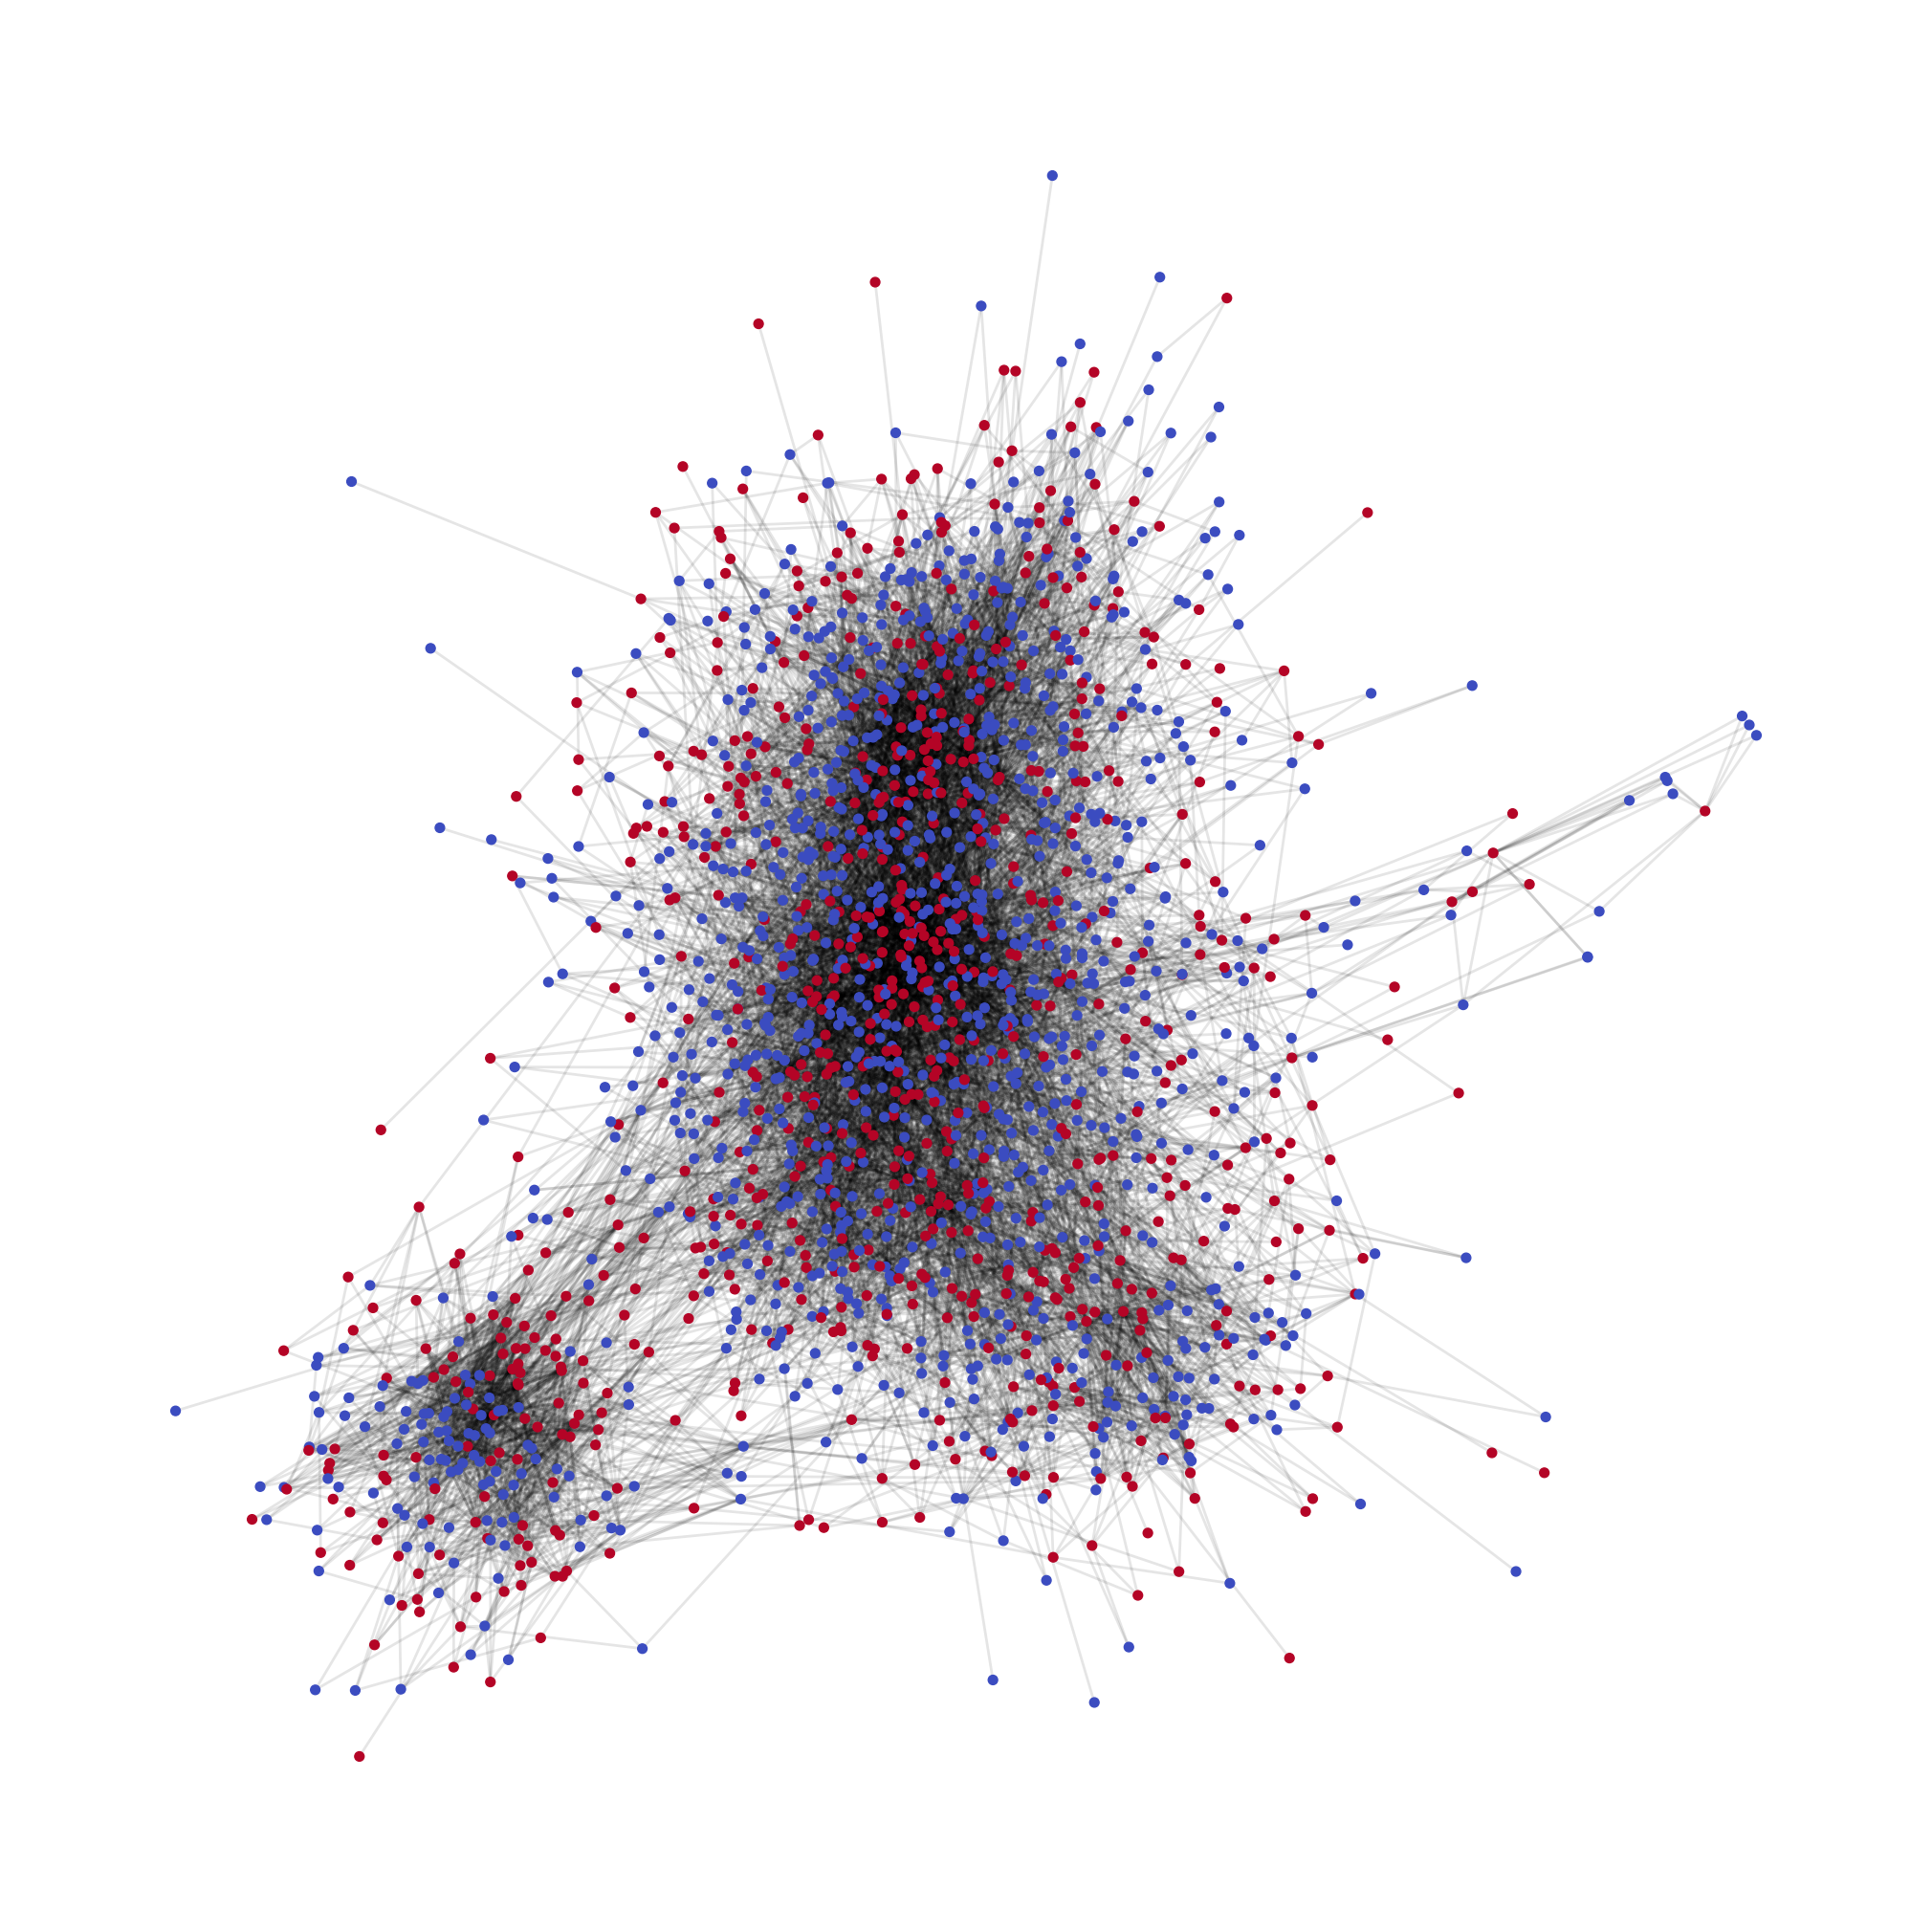

In [11]:
# Graph the large subgraph
color_map = {"playlist": 0, "track": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_lg.nodes(data=True)]
plt.figure(figsize=(20,20))
nx.draw(sub_G_lg,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 50,
        width = 2,
        edge_color=(0, 0, 0, 0.1))

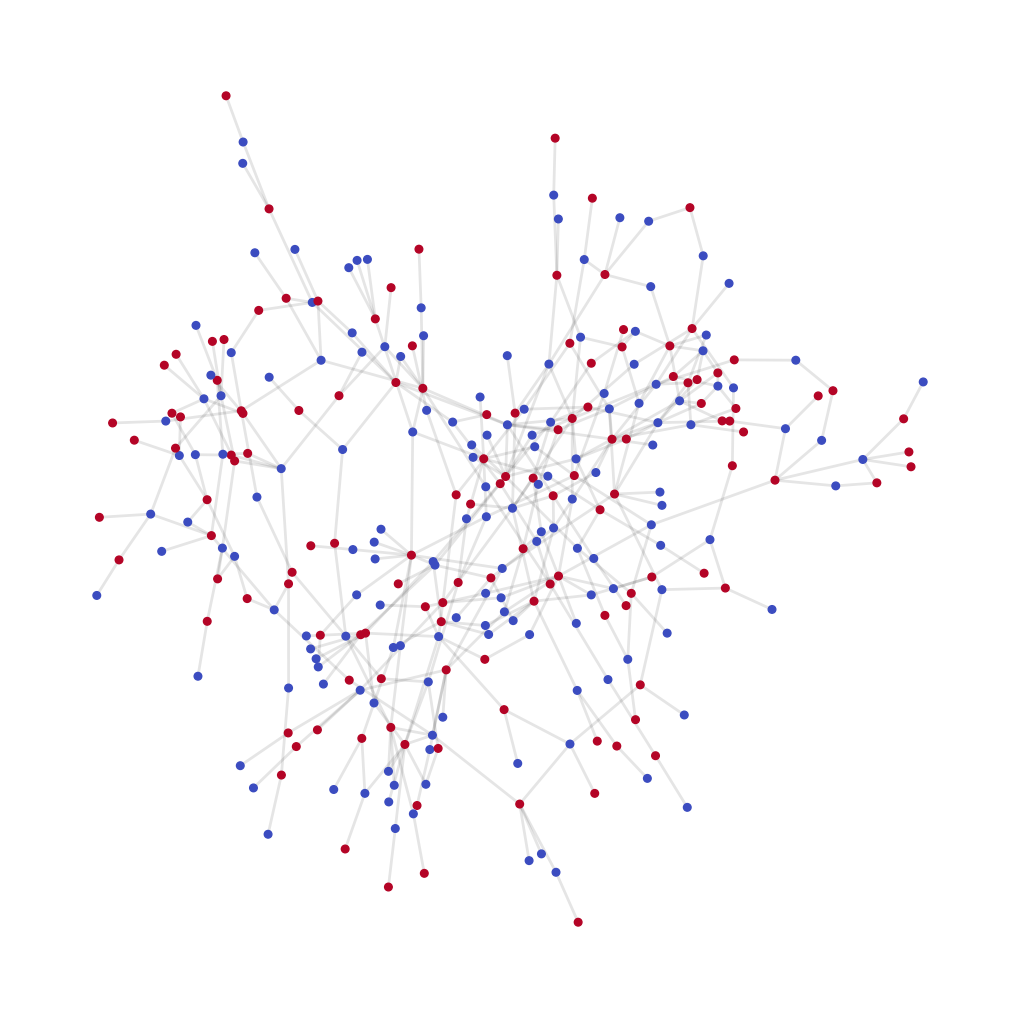

In [12]:
# Graph the subgraph of the small subgraph
color_map = {"playlist": 0, "track": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_sm.nodes(data=True)]
plt.figure(figsize=(10,10))
nx.draw(sub_G_sm,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 2,
        edge_color=(0, 0, 0, 0.1))

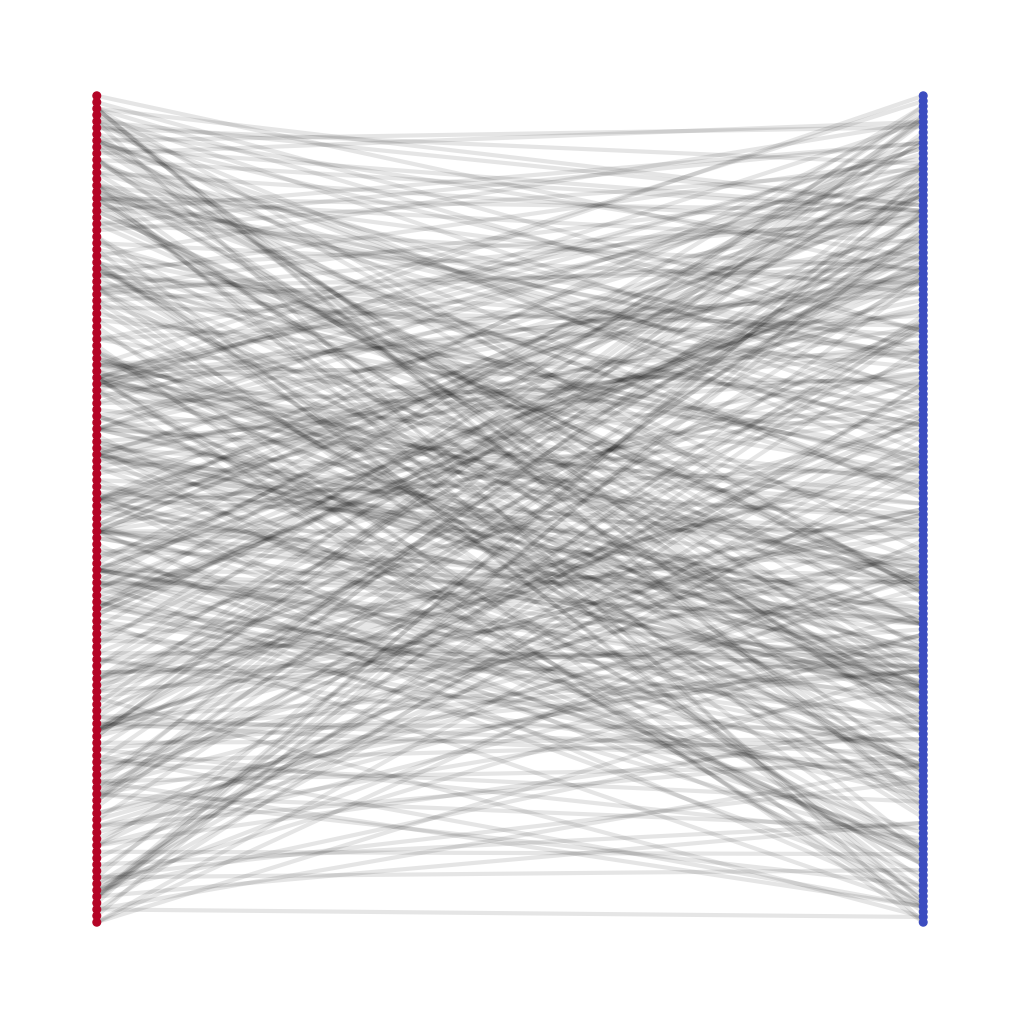

In [13]:
# Show the smaller subgraph as bipartite
top = nx.bipartite.sets(sub_G_sm)[0]
pos = nx.bipartite_layout(sub_G_sm, top)
plt.figure(figsize=(10,10))
nx.draw(sub_G_sm,
        pos=pos,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 3,
        edge_color=(0, 0, 0, 0.1))

In [14]:
# Note if you've already generated the graph above, you can skip those steps, and simply run set reload to True!
reload = False
if reload: 
  G = pickle.load(open("30core_first_50.pkl", "rb"))
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 15720 . Num edges: 628743


In [15]:
n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = sorted(list(G.nodes()))

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

G = nx.relabel_nodes(G, node2id)

# also keep track of how many playlists, tracks we have
playlists_idx = [i for i, v in enumerate(node2id.keys()) if "playlist" in v]
tracks_idx = [i for i, v in enumerate(node2id.keys()) if "track" in v]

n_playlists = np.max(playlists_idx) + 1
n_tracks = n_nodes - n_playlists

n_playlists, n_tracks

(9421, 6299)

In [19]:
len(playlists_idx)

9421

In [16]:
import pickle
with open("playlists_idx.dat","wb") as f:
    pickle.dump(playlists_idx,f)
with open("tracks_idx.dat","wb") as f:
    pickle.dump(tracks_idx,f)

In [58]:
num_nodes = n_playlists +  n_tracks
edge_idx = torch.Tensor(np.array(G.edges()).T)
graph_data = Data(edge_index = edge_idx, num_nodes = num_nodes)

In [59]:
torch.save(graph_data,'playlist_data.pt')

In [60]:
graph_data2 = torch.load('playlist_data.pt')

Split the data into train-test-split sets.

In [61]:
transform = RandomLinkSplit(
    is_undirected=True, 
    add_negative_train_samples=False, 
    neg_sampling_ratio=0,
    num_val=0.15, num_test=0.15
)
train_split, val_split, test_split = transform(graph_data)

In [62]:
# note these are stored as float32, we need them to be int64 for future training

# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positives upervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 219346 positives upervision edges
Validation set has 47002 positive supervision edges
Test set has 47002 positive supervision edges
Train set has 438692 message passing edges
Validation set has 438692 message passing edges
Test set has 532696 message passing edges


### The GCN class
As mentioned, the primary model type we need here is a GCN. Use this boilerplate code to define your GCN code. This is merely a template, you can change it up if you think something else would be more intuitive.

In [71]:
class GCN(torch.nn.Module):
    """
      Here we adapt the LightGCN model from Torch Geometric for our purposes. We allow 
      for customizable convolutional layers, custom embeddings. In addition, we deifne some 
      additional custom functions. 

    """

    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable = False,
        conv_layer = "LGC",
        name = None,
        **kwargs,
    ):
        super().__init__()
        alpha_string = "alpha" if alpha_learnable else ""
        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        if alpha_learnable == True:
          alpha_vals = torch.rand(num_layers+1)
          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))
          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")
        else:
          if alpha is None:
              alpha = 1. / (num_layers + 1)

          if isinstance(alpha, Tensor):
              assert alpha.size(0) == num_layers + 1
          else:
              alpha = torch.tensor([alpha] * (num_layers + 1))

        self.register_buffer('alpha', alpha)

        self.embedding = Embedding(num_nodes, embedding_dim)

        # initialize convolutional layers 
        self.conv_layer = conv_layer
        if conv_layer == "LGC":  
          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight
        
        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if self.conv_layer == "GAT":
              x = self.linears[i](x)
            out = out + x * weights[i + 1]

        return out

    def initialize_embeddings(self, data):
      # initialize with the data node features
        self.embedding.weight.data.copy_(data.node_feature)


    def forward(self, edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            if isinstance(edge_index, SparseTensor):
                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)
            else:
                edge_label_index = edge_index

        out = self.get_embedding(edge_index)

        return self.predict_link_embedding(out, edge_label_index)

    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,
                     prob: bool = False) -> Tensor:
       
        pred = self(edge_index, edge_label_index).sigmoid()
        return pred if prob else pred.round()
    
    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor: 

        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        return (embed_src * embed_dst).sum(dim=-1)


    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        out_src = out_dst = self.get_embedding(edge_index)

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:  # Map local top-indices to original indices.
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,
                       **kwargs) -> Tensor:
        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)
        return loss_fn(pred, edge_label.to(pred.dtype))


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        r"""Computes the model loss for a ranking objective via the Bayesian
        Personalized Ranking (BPR) loss."""
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)
    
    def bpr_loss(self, pos_scores, neg_scores):
      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.num_nodes}, '
                f'{self.embedding_dim}, num_layers={self.num_layers})')


You'll need a new kind of Loss function for this task, so here's a class for implementing BPR, Bayesian Personalised Ranking Loss. We've implemented this for you. Hopefully it helps. You can change function names and stuff, however you are forbidden from changing the mathematical formula -

\begin{equation*}
    \text{BPR Loss}(i) = \frac{1}{|\mathcal{E}(i)|} \underset{{(i, j_{+}) \in \mathcal{E}(i)}}{\sum} \log \sigma \left( \text{score}(i, j_+) - \text{score}(i, j_-) \right)
\end{equation*}

In [72]:
class BPRLoss(_Loss):
    r"""The Bayesian Personalized Ranking (BPR) loss.

    The BPR loss is a pairwise loss that encourages the prediction of an
    observed entry to be higher than its unobserved counterparts
    (see `here <https://arxiv.org/abs/2002.02126>`__).

    .. math::
        L_{\text{BPR}} = - \sum_{u=1}^{M} \sum_{i \in \mathcal{N}_u}
        \sum_{j \not\in \mathcal{N}_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj})
        + \lambda \vert\vert \textbf{x}^{(0)} \vert\vert^2

    where :math:`lambda` controls the :math:`L_2` regularization strength.
    We compute the mean BPR loss for simplicity.

    Args:
        lambda_reg (float, optional): The :math:`L_2` regularization strength
            (default: 0).
        **kwargs (optional): Additional arguments of the underlying
            :class:`torch.nn.modules.loss._Loss` class.
    """
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        r"""Compute the mean Bayesian Personalized Ranking (BPR) loss.

        .. note::

            The i-th entry in the :obj:`positives` vector and i-th entry
            in the :obj:`negatives` entry should correspond to the same
            entity (*.e.g*, user), as the BPR is a personalized ranking loss.

        Args:
            positives (Tensor): The vector of positive-pair rankings.
            negatives (Tensor): The vector of negative-pair rankings.
            parameters (Tensor, optional): The tensor of parameters which
                should be used for :math:`L_2` regularization
                (default: :obj:`None`).
        """
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2) 

        return (-log_prob + regularization) / n_pairs

If you only trained the model to minimise loss however, your model would perform pretty poorly. Why so? Assign every node the same embedding, and you would technically be minimizing the loss. The solution to that usually involves negative sampling, paying attention to the nodes that do not have an edge between them and hence must not be similar. 
Here are some negative sampling approaches for you to try out. We've done the first one, you do the rest - 
1. Random, no positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. For computational efficiency, we don't check if ($p_i$, $t_j$) is actually a negative edge, though probabilistically it is very likely.
2. Random, positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. We ensure that ($p_i$, $t_j$) is not a positive edge. 
3. Hard: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the top $k$ proportion of tracks, ranked by dot product similarity to $p_i$. For epoch 0, $k = 1$ and we lower it at each subsequent iteration. 

In [73]:
def sample_negative_edges_nocheck(data, num_playlists, num_tracks, device = None):
  # note computationally inefficient to check that these are indeed negative edges
  playlists = data.edge_label_index[0, :]
  tracks = torch.randint(num_playlists, num_playlists + num_tracks - 1, size = data.edge_label_index[1, :].size())

  if playlists.get_device() != -1: # on gpu 
    tracks = tracks.to(device)

  neg_edge_index = torch.stack((playlists, tracks), dim = 0)
  neg_edge_label = torch.zeros(neg_edge_index.shape[1])

  if neg_edge_index.get_device() != -1: # on gpu 
    neg_edge_label = neg_edge_label.to(device)
    
  return neg_edge_index, neg_edge_label

def sample_negative_edges(data, num_playlists, num_tracks, device=None):
    positive_playlists, positive_tracks = data.edge_label_index

    # Create a mask tensor with the shape (num_playlists, num_tracks)
    mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    mask[positive_playlists, positive_tracks - num_playlists] = True

    # Flatten the mask tensor and get the indices of the negative edges
    flat_mask = mask.flatten()
    negative_indices = torch.where(~flat_mask)[0]

    # Sample negative edges from the negative_indices tensor
    sampled_negative_indices = negative_indices[
        torch.randint(0, negative_indices.size(0), size=(positive_playlists.size(0),), device=device)
    ]

    # Convert the indices back to playlists and tracks tensors
    playlists = torch.floor_divide(sampled_negative_indices, num_tracks)
    tracks = torch.remainder(sampled_negative_indices, num_tracks)
    tracks = tracks + num_playlists

    neg_edge_index = torch.stack((playlists, tracks), dim=0)
    neg_edge_label = torch.zeros(neg_edge_index.shape[1], device=device)

    return neg_edge_index, neg_edge_label

def sample_hard_negative_edges(data, model, num_playlists, num_tracks, device=None, batch_size=500, frac_sample = 1):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:num_playlists].to(device)
        tracks_embeddings = embeddings[num_playlists:].to(device)

    positive_playlists, positive_tracks = data.edge_label_index
    num_edges = positive_playlists.size(0)

    # Create a boolean mask for all the positive edges
    positive_mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    positive_mask[positive_playlists, positive_tracks - num_playlists] = True

    neg_edges_list = []
    neg_edge_label_list = []

    for batch_start in range(0, num_edges, batch_size):
        batch_end = min(batch_start + batch_size, num_edges)

        batch_scores = torch.matmul(
            playlists_embeddings[positive_playlists[batch_start:batch_end]], tracks_embeddings.t()
        )

        # Set the scores of the positive edges to negative infinity
        batch_scores[positive_mask[positive_playlists[batch_start:batch_end]]] = -float("inf")

        # Select the top k highest scoring negative edges for each playlist in the current batch
        # do 0.99 to filter out all pos edges which will be at the end 
        _, top_indices = torch.topk(batch_scores, int(frac_sample * 0.99 * num_tracks), dim=1)
        selected_indices = torch.randint(0, int(frac_sample * 0.99 *num_tracks), size = (batch_end - batch_start, ))
        top_indices_selected = top_indices[torch.arange(batch_end - batch_start), selected_indices] + n_playlists

        # Create the negative edges tensor for the current batch
        neg_edges_batch = torch.stack(
            (positive_playlists[batch_start:batch_end], top_indices_selected), dim=0
        )
        neg_edge_label_batch = torch.zeros(neg_edges_batch.shape[1], device=device)

        neg_edges_list.append(neg_edges_batch)
        neg_edge_label_list.append(neg_edge_label_batch)

    # Concatenate the batch tensors
    neg_edges = torch.cat(neg_edges_list, dim=1)
    neg_edge_label = torch.cat(neg_edge_label_list)

    return neg_edges, neg_edge_label

Using only a loss seems like a bad idea however. Most of the time it can be quite hard to interpret loss alone. So let's just also keep an eye on the Recall@K, a popular one for RecSys.
For a playlist $i$, $P^k_i$ represents the set of the top $k$ predicted tracks for $i$ and $T_i$ the ground truth of connected tracks to playlist $i$, then we calculate 
$$
\text{recall}^k_i = \frac{| P^k_i \cap T_i | }{|T_i|}.
$$
If $T_i = 0$, then we assign this value to 1 (We don't really want to run into ZeroDivisionError). Note, if $T_i \subset P_i^k$, then the recall is equal to 1. Hence, our choice of $k$ matters a lot. 

You'll probably want to try out multiple values of k but maybe you can start in the ballpark of 2-3% of the total tracks
Note: When you evaluate this metric on the val or test set, make sure to filter the message passing edges from consideration, as the model can directly observe these.

In [74]:
def recall_at_k(data, model, k = 300, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[n_playlists:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

Finally, let's calculate the ROC AUC score for the binary predictions, which provides a measure of the efficiency of our model at distinguishing `true' track-playlist edges from non-existing ones. The higher this score, the better (a perfect score is achieved when ROC AUC = 1). This is done for you here - 

In [75]:
def metrics(labels, preds):
  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
  return roc 

Finally. It's time to write your train and test functions for training and evaluation.

In [76]:
# Train
def train(datasets, model, optimizer, loss_fn, args, neg_samp = "random"):
  print(f"Beginning training for {model.name}")

  train_data = datasets["train"]
  val_data = datasets["val"]

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [], 
        'roc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]): # loop over each epoch 
    model.train()
    optimizer.zero_grad()
    
    # obtain negative sample
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(train_data, n_playlists, n_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0: 
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            train_data, model, n_playlists, n_tracks, args["device"], batch_size = 500, 
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # calculate embedding
    embed = model.get_embedding(train_data.edge_index)
    # calculate pos, negative scores using embedding
    pos_scores = model.predict_link_embedding(embed, train_data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss 
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)

    # calculate loss function 
    if loss_fn == "BCE": 
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)
    
    train_roc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_neg_edge, val_neg_label = test(
        model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label
    )

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")

    if epoch % 10 == 0: 
      # calculate recall @ K
      val_recall = recall_at_k(val_data, model, k = 300, device = args["device"])
      print(f"Val recall {val_recall}")
      stats['val']['recall'].append(val_recall)

    if epoch % 20 == 0: 

      # save embeddings for future visualization 
      path = os.path.join("model_embeddings", model.name)
      if not os.path.exists(path):
        os.makedirs(path)
      torch.save(model.embedding.weight, os.path.join("model_embeddings", model.name, f"{model.name}_{loss_fn}_{neg_samp}_{epoch}.pt"))

  pickle.dump(stats, open(f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pkl", "wb"))
  return stats

def test(model, data, loss_fn, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None):
  
  model.eval()
  with torch.no_grad(): # want to save RAM 

    # conduct negative sampling 
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(data, n_playlists, n_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0 or neg_edge_index is None: 
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            data, model, n_playlists, n_tracks, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # obtain model embedding
    embed = model.get_embedding(data.edge_index)
    # calculate pos, neg scores using embedding 
    pos_scores = model.predict_link_embedding(embed, data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)
    # concatenate pos, neg scores together and evaluate loss 
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)
    # calculate loss 
    if loss_fn == "BCE": 
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    roc = metrics(labels, scores)
    
  return loss, roc, neg_edge_index, neg_edge_label

## Start your training

Maybe put your splits in a dict for easy access?

In [77]:
datasets = {
    'train':train_split, 
    'val':val_split, 
    'test': test_split 
}

In [78]:
training_args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',  # For the love of God, please do use a GPU though.
    'num_layers' :  3,
    'emb_size' : 64,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 301
}

Initialise your model with the parameters and nodes and whatever.
The Adam optimizer should work just fine for the task, so initialise that well as well.

In [79]:
# initialize model and and optimizer 
num_nodes = n_playlists + n_tracks
model = GCN(
    num_nodes = num_nodes, num_layers = training_args['num_layers'], 
    embedding_dim = training_args["emb_size"], conv_layer = "LGC"
)
optimizer = torch.optim.Adam(model.parameters(), lr=training_args['lr'], weight_decay=training_args['weight_decay'])

It's time to put this data on a GPU.

In [80]:
playlists_idx = torch.Tensor(playlists_idx).type(torch.int64).to(training_args["device"])
tracks_idx =torch.Tensor(tracks_idx).type(torch.int64).to(training_args["device"])
datasets['train'].to(training_args['device'])
datasets['val'].to(training_args['device'])
datasets['test'].to(training_args['device'])
model.to(training_args["device"])

GCN(15720, 64, num_layers=3)

In [43]:
# create directory to save model_stats
MODEL_STATS_DIR = "model_stats"
if not os.path.exists(MODEL_STATS_DIR):
  os.makedirs(MODEL_STATS_DIR)

In [81]:
train(datasets, model, optimizer, "BPR", training_args, neg_samp = "random")

Beginning training for LGCN_LGC_3_e64_nodes15720_


C:\Users\Aniruddh\AppData\Local\Temp\ipykernel_19404\3134013971.py:34: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\aten\src\ATen\native\BinaryOps.cpp:600.)
  playlists = torch.floor_divide(sampled_negative_indices, num_tracks)


Epoch 0; Train loss 0.693130612373352; Val loss 0.6931297183036804; Train ROC 0.6281433552155685; Val ROC 0.7629493290965743
Val recall 0.37520748376846313
Epoch 1; Train loss 0.6931234002113342; Val loss 0.6928590536117554; Train ROC 0.8715728070936885; Val ROC 0.871477106753292
Epoch 2; Train loss 0.6928421854972839; Val loss 0.6915072798728943; Train ROC 0.8876255689891415; Val ROC 0.8672538077479077
Epoch 3; Train loss 0.6914202570915222; Val loss 0.6882250308990479; Train ROC 0.8814624168178602; Val ROC 0.8688790902016865
Epoch 4; Train loss 0.6880167126655579; Val loss 0.6825791001319885; Train ROC 0.8808938379944726; Val ROC 0.8680386605973984
Epoch 5; Train loss 0.6821014285087585; Val loss 0.6741864681243896; Train ROC 0.8809438868717085; Val ROC 0.8672771210647946
Epoch 6; Train loss 0.6733013987541199; Val loss 0.6627042889595032; Train ROC 0.8806855399936394; Val ROC 0.8685347478466572
Epoch 7; Train loss 0.6614275574684143; Val loss 0.6483815908432007; Train ROC 0.88076286

{'train': {'loss': [tensor(0.6931, grad_fn=<DivBackward0>),
   tensor(0.6931, grad_fn=<DivBackward0>),
   tensor(0.6928, grad_fn=<DivBackward0>),
   tensor(0.6914, grad_fn=<DivBackward0>),
   tensor(0.6880, grad_fn=<DivBackward0>),
   tensor(0.6821, grad_fn=<DivBackward0>),
   tensor(0.6733, grad_fn=<DivBackward0>),
   tensor(0.6614, grad_fn=<DivBackward0>),
   tensor(0.6464, grad_fn=<DivBackward0>),
   tensor(0.6284, grad_fn=<DivBackward0>),
   tensor(0.6073, grad_fn=<DivBackward0>),
   tensor(0.5835, grad_fn=<DivBackward0>),
   tensor(0.5581, grad_fn=<DivBackward0>),
   tensor(0.5312, grad_fn=<DivBackward0>),
   tensor(0.5037, grad_fn=<DivBackward0>),
   tensor(0.4759, grad_fn=<DivBackward0>),
   tensor(0.4495, grad_fn=<DivBackward0>),
   tensor(0.4238, grad_fn=<DivBackward0>),
   tensor(0.4015, grad_fn=<DivBackward0>),
   tensor(0.3788, grad_fn=<DivBackward0>),
   tensor(0.3595, grad_fn=<DivBackward0>),
   tensor(0.3434, grad_fn=<DivBackward0>),
   tensor(0.3282, grad_fn=<DivBackwar

In [82]:
test(model, datasets['test'], "BPR", neg_samp = "random")

(tensor(0.2828),
 0.9177777770967834,
 tensor([[ 2980,  3463,  4089,  ...,  3624,  5277,  4211],
         [15581, 11334, 14564,  ..., 10996, 13565, 11428]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [83]:
def init_model(conv_layer, args, alpha = False):
  num_nodes = n_playlists + n_tracks
  model = GCN(
      num_nodes = num_nodes, num_layers = args['num_layers'], 
      embedding_dim = args["emb_size"], conv_layer = conv_layer, 
      alpha_learnable = alpha
  )
  model.to(args["device"])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  return model, optimizer 

In [85]:
## For example:

# using BPR loss
loss_fn = "BPR"

# using hard sampling
neg_samp = "hard"

# for LGConv: 
training_args['epochs'] = 301
training_args['num_layers'] = 4
model, optimizer = init_model("LGC", training_args)
lgc_stats_hard = train(datasets, model, optimizer, loss_fn, training_args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes15720_
Epoch 0; Train loss 0.6931363344192505; Val loss 0.6931356191635132; Train ROC 0.6307250199599388; Val ROC 0.7634348009070576
Val recall 0.39111173152923584
Epoch 1; Train loss 0.6931315660476685; Val loss 0.6929593682289124; Train ROC 0.8642389397724495; Val ROC 0.8195180255016449
Epoch 2; Train loss 0.692947506904602; Val loss 0.6919912695884705; Train ROC 0.8341681340328861; Val ROC 0.8143801947785698
Epoch 3; Train loss 0.6919256448745728; Val loss 0.6894998550415039; Train ROC 0.8263316053409921; Val ROC 0.8147800172465539
Epoch 4; Train loss 0.6893013715744019; Val loss 0.6849682927131653; Train ROC 0.8261567735991802; Val ROC 0.8149917914365065
Epoch 5; Train loss 0.6846718192100525; Val loss 0.6783539652824402; Train ROC 0.8243415426081337; Val ROC 0.8116431742130717
Epoch 6; Train loss 0.6775014400482178; Val loss 0.6690093278884888; Train ROC 0.8243309508030192; Val ROC 0.8114821535125446
Epoch 7; Train loss 0.667625367641449;